In [58]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import io
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import glob

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [59]:

train_data_dir = 'train'
img_width = 64
img_height = 64
img_dim = img_width * img_height * 3 #RGB images
batch_size = 8



In [60]:
def get_images_from_directory(dir_path,extensions = ['jpg','jpeg','png']):
    '''
        Extracts filepaths of all the images with specified extensions from a folder
        
        Input:
            dir_path: string, full directory path
            extensions = list, list of valid extensions
        Output:
            list of valid filepaths
    '''
    
    types = ['{}/*.{}'.format(dir_path,e) for e in extensions]

    files_grabbed = []
    
    for files in types:
        files_grabbed.extend(glob.glob(files))
    
    return files_grabbed


In [61]:

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [62]:
# network parameters
input_shape = (img_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2



In [63]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(img_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          6291968     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [64]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= img_dim 
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12288)             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 6294020   
_________________________________________________________________
decoder (Model)              (None, 12288)             6305280   
Total params: 12,599,300
Trainable params: 12,599,300
Non-trainable params: 0
_________________________________________________________________


In [65]:
#process head dicom images
head_files =  get_images_from_directory("train\\head\\")
X_train = []
y_train = []
for file in head_files:
    img = load_img(file, target_size=(img_height, img_width))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    X_train.append(x)
    
imgs = np.concatenate(X_train, axis=0)
imgs.shape
X_train = np.reshape(imgs, [-1, img_dim])
X_train = X_train.astype('float32') / 255
X_train.shape

(50, 12288)

In [66]:
TEST_SIZE = 25
SAMPLE_SIZE = X_train.shape[0]
TRAIN_SIZE = SAMPLE_SIZE - TEST_SIZE
x_train = X_train[:TRAIN_SIZE]
x_test = X_train[TRAIN_SIZE:SAMPLE_SIZE]
x_train.shape, x_test.shape
epochs = 200

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 25 samples, validate on 25 samples
Epoch 1/200
25/25 [==============================] - 2s 85ms/step - loss: 8528.7148 - val_loss: 7948.4575
Epoch 2/200
25/25 [==============================] - 0s 10ms/step - loss: 7943.9614 - val_loss: 5357.7988
Epoch 3/200
25/25 [==============================] - 0s 10ms/step - loss: 5264.9937 - val_loss: 5411.2358
Epoch 4/200
25/25 [==============================] - 0s 9ms/step - loss: 5211.5361 - val_loss: 4097.6689
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 3948.1697 - val_loss: 2838.0503
Epoch 6/200
25/25 [==============================] - 0s 10ms/step - loss: 2769.3271 - val_loss: 2997.6626
Epoch 7/200
25/25 [==============================] - 0s 9ms/step - loss: 2974.3552 - val_loss: 2569.1042
Epoch 8/200
25/25 [==============================] - 0s 9ms/step - loss: 2544.4773 - val_loss: 2036.1779
Epoch 9/200
25/25 [==============================] - 0s 9ms/step - loss: 1987.6389 - val_loss: 2237.0000
Epoch 1

Epoch 78/200
25/25 [==============================] - 0s 9ms/step - loss: 975.9896 - val_loss: 1058.7494
Epoch 79/200
25/25 [==============================] - 0s 9ms/step - loss: 974.3908 - val_loss: 1055.8235
Epoch 80/200
25/25 [==============================] - 0s 9ms/step - loss: 972.0097 - val_loss: 1057.0776
Epoch 81/200
25/25 [==============================] - 0s 9ms/step - loss: 968.8859 - val_loss: 1053.4805
Epoch 82/200
25/25 [==============================] - 0s 10ms/step - loss: 968.1810 - val_loss: 1048.7465
Epoch 83/200
25/25 [==============================] - 0s 9ms/step - loss: 963.2372 - val_loss: 1045.0498
Epoch 84/200
25/25 [==============================] - 0s 9ms/step - loss: 964.2271 - val_loss: 1046.9089
Epoch 85/200
25/25 [==============================] - 0s 9ms/step - loss: 961.3148 - val_loss: 1044.6772
Epoch 86/200
25/25 [==============================] - 0s 9ms/step - loss: 958.8628 - val_loss: 1040.8994
Epoch 87/200
25/25 [==============================] - 

Epoch 155/200
25/25 [==============================] - 0s 9ms/step - loss: 1193.9421 - val_loss: 1236.4840
Epoch 156/200
25/25 [==============================] - 0s 10ms/step - loss: 1170.3134 - val_loss: 1196.9165
Epoch 157/200
25/25 [==============================] - 0s 9ms/step - loss: 1132.7677 - val_loss: 1159.9025
Epoch 158/200
25/25 [==============================] - 0s 9ms/step - loss: 1089.8405 - val_loss: 1159.8672
Epoch 159/200
25/25 [==============================] - 0s 9ms/step - loss: 1077.2734 - val_loss: 1178.0789
Epoch 160/200
25/25 [==============================] - 0s 9ms/step - loss: 1099.0490 - val_loss: 1200.4150
Epoch 161/200
25/25 [==============================] - 0s 9ms/step - loss: 1098.2905 - val_loss: 1171.1063
Epoch 162/200
25/25 [==============================] - 0s 9ms/step - loss: 1071.6453 - val_loss: 1142.5950
Epoch 163/200
25/25 [==============================] - 0s 10ms/step - loss: 1059.7738 - val_loss: 1146.2474
Epoch 164/200
25/25 [==============

In [67]:
z_mean_head, _, _ = encoder.predict(x_test, batch_size = batch_size)

In [69]:
#process heart dicom images
heart_files =  get_images_from_directory("train\\heart\\")
X_train = []
y_train = []
for file in heart_files:
    img = load_img(file, target_size=(img_height, img_width))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    X_train.append(x)
    
imgs = np.concatenate(X_train, axis=0)
imgs.shape
X_train = np.reshape(imgs, [-1, img_dim])
X_train = X_train.astype('float32') / 255
X_train.shape

(190, 12288)

In [70]:
TEST_SIZE = 25
SAMPLE_SIZE = X_train.shape[0]
TRAIN_SIZE = SAMPLE_SIZE - TEST_SIZE
x2_train = X_train[:TRAIN_SIZE]
x2_test = X_train[TRAIN_SIZE:SAMPLE_SIZE]
x2_train.shape, x2_test.shape
epochs = 200

vae.fit(x2_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x2_test, None))

Train on 165 samples, validate on 25 samples
Epoch 1/200
165/165 [==============================] - 1s 4ms/step - loss: 4528.5355 - val_loss: 5144.9146
Epoch 2/200
165/165 [==============================] - 1s 4ms/step - loss: 5126.5767 - val_loss: 4576.2129
Epoch 3/200
165/165 [==============================] - 1s 4ms/step - loss: 4568.8681 - val_loss: 3820.2727
Epoch 4/200
165/165 [==============================] - 1s 4ms/step - loss: 3744.4559 - val_loss: 3423.9893
Epoch 5/200
165/165 [==============================] - 1s 4ms/step - loss: 3406.5420 - val_loss: 3275.4263
Epoch 6/200
165/165 [==============================] - 1s 4ms/step - loss: 3256.0431 - val_loss: 3215.7329
Epoch 7/200
165/165 [==============================] - 1s 3ms/step - loss: 3158.1443 - val_loss: 3158.2166
Epoch 8/200
165/165 [==============================] - 1s 4ms/step - loss: 3093.7525 - val_loss: 3100.1150
Epoch 9/200
165/165 [==============================] - 1s 4ms/step - loss: 3045.1531 - val_loss: 30

165/165 [==============================] - 1s 4ms/step - loss: 2799.7201 - val_loss: 2833.1057
Epoch 77/200
165/165 [==============================] - 1s 4ms/step - loss: 2799.5264 - val_loss: 2833.9092
Epoch 78/200
165/165 [==============================] - 1s 4ms/step - loss: 2799.1448 - val_loss: 2833.6130
Epoch 79/200
165/165 [==============================] - 1s 4ms/step - loss: 2798.8672 - val_loss: 2834.9956
Epoch 80/200
165/165 [==============================] - 1s 4ms/step - loss: 2798.9929 - val_loss: 2834.2278
Epoch 81/200
165/165 [==============================] - 1s 4ms/step - loss: 2798.2645 - val_loss: 2833.9888
Epoch 82/200
165/165 [==============================] - 1s 3ms/step - loss: 2797.2029 - val_loss: 2832.9385
Epoch 83/200
165/165 [==============================] - 1s 4ms/step - loss: 2796.5491 - val_loss: 2830.9580
Epoch 84/200
165/165 [==============================] - 1s 4ms/step - loss: 2795.7717 - val_loss: 2829.8003
Epoch 85/200
165/165 [===================

165/165 [==============================] - 1s 4ms/step - loss: 2773.5698 - val_loss: 2806.7466
Epoch 152/200
165/165 [==============================] - 1s 4ms/step - loss: 2772.9897 - val_loss: 2807.1060
Epoch 153/200
165/165 [==============================] - 1s 4ms/step - loss: 2773.5680 - val_loss: 2805.1917
Epoch 154/200
165/165 [==============================] - 1s 4ms/step - loss: 2772.8981 - val_loss: 2804.9031
Epoch 155/200
165/165 [==============================] - 1s 4ms/step - loss: 2772.5301 - val_loss: 2805.1184
Epoch 156/200
165/165 [==============================] - 1s 4ms/step - loss: 2772.0650 - val_loss: 2805.9524
Epoch 157/200
165/165 [==============================] - 1s 4ms/step - loss: 2772.0003 - val_loss: 2806.4888
Epoch 158/200
165/165 [==============================] - 1s 4ms/step - loss: 2771.8102 - val_loss: 2807.1873
Epoch 159/200
165/165 [==============================] - 1s 4ms/step - loss: 2771.8201 - val_loss: 2806.1584
Epoch 160/200
165/165 [==========

In [71]:

z_mean_heart, _, _ = encoder.predict(x2_test, batch_size = batch_size)
len(z_mean_head), len(z_mean_heart)


(25, 25)

In [72]:
z_mean = np.empty(shape=(50,2))
y_label = []
for i in range(25):
    for j in range(2):
        z_mean[i,j] = z_mean_head[i,j]
    y_label.append(0)
for i in range(25):
    for j in range(2):
        z_mean[25+i,j] = z_mean_heart[i,j]
    y_label.append(1)    
    

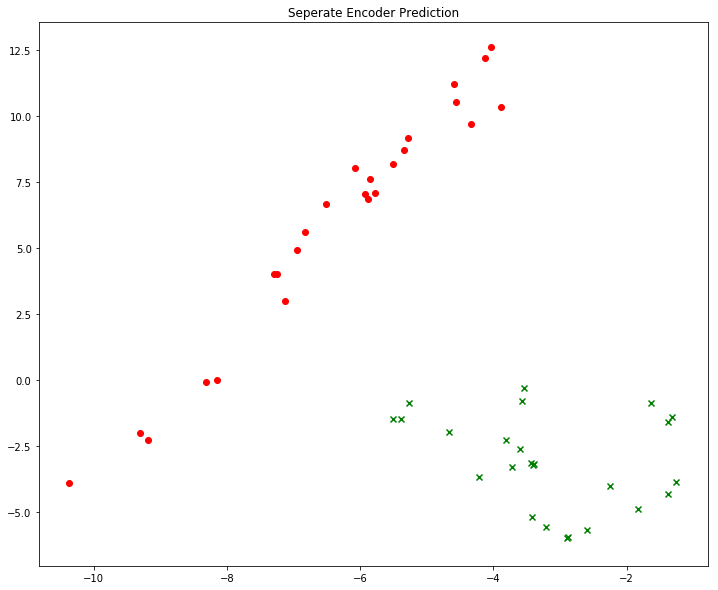

In [73]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:25,0], z_mean[:25,1], marker = 'o', c='r') #red- head
plt.scatter(z_mean[25:,0], z_mean[25:,1], marker = 'x', c='g') #green - heart
plt.title('Seperate Encoder Prediction')
plt.show()

Text(0.5, 1.0, 'KMeans Clustering - Seperate Encoder')

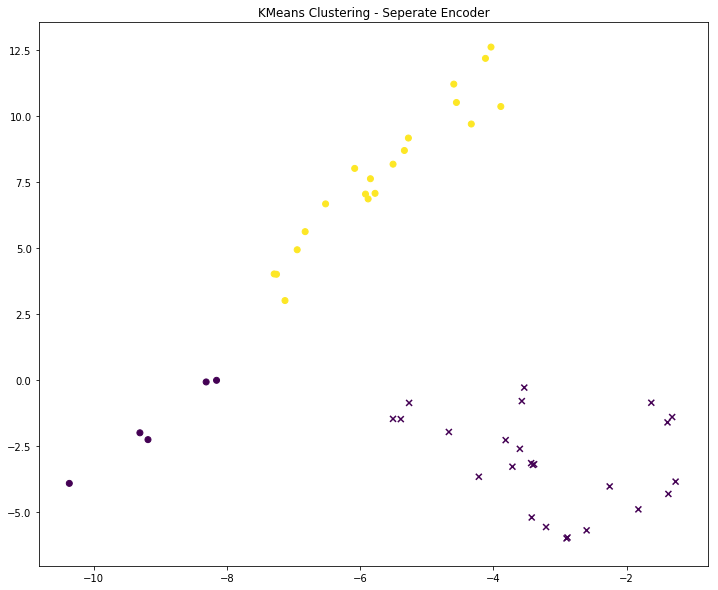

In [76]:
random_state = 170
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(z_mean)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:25,0], z_mean[:25,1], marker = 'o', c=y_pred[0:25])  #head
plt.scatter(z_mean[25:,0], z_mean[25:,1], marker = 'x', c=y_pred[25:50]) #heart
plt.title("KMeans Clustering - Seperate Encoder")

In [77]:
## one network - feed both image types

combined_train = np.concatenate((x_train, x2_train), axis=0)
print(x_train.shape, x2_train.shape, combined_train.shape)
combined_test = np.concatenate((x_test, x2_test), axis=0)
print(x_test.shape, x2_test.shape, combined_test.shape)

(25, 12288) (165, 12288) (190, 12288)
(25, 12288) (25, 12288) (50, 12288)


In [78]:
epochs = 200

vae.fit(combined_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(combined_test, None))

Train on 190 samples, validate on 50 samples
Epoch 1/200
190/190 [==============================] - 1s 3ms/step - loss: 2570.9591 - val_loss: 2070.0959
Epoch 2/200
190/190 [==============================] - 1s 4ms/step - loss: 2561.9356 - val_loss: 2037.4628
Epoch 3/200
190/190 [==============================] - 1s 4ms/step - loss: 2554.8673 - val_loss: 2023.7169
Epoch 4/200
190/190 [==============================] - 1s 3ms/step - loss: 2553.7897 - val_loss: 2014.2119
Epoch 5/200
190/190 [==============================] - 1s 3ms/step - loss: 2552.4632 - val_loss: 2007.8160
Epoch 6/200
190/190 [==============================] - 1s 3ms/step - loss: 2547.0937 - val_loss: 1998.0229
Epoch 7/200
190/190 [==============================] - 1s 4ms/step - loss: 2546.5941 - val_loss: 1990.9448
Epoch 8/200
190/190 [==============================] - 1s 3ms/step - loss: 2543.0621 - val_loss: 1987.2007
Epoch 9/200
190/190 [==============================] - 1s 3ms/step - loss: 2541.7256 - val_loss: 19

190/190 [==============================] - 1s 3ms/step - loss: 2512.5162 - val_loss: 1921.4850
Epoch 77/200
190/190 [==============================] - 1s 3ms/step - loss: 2511.4515 - val_loss: 1919.9899
Epoch 78/200
190/190 [==============================] - 1s 3ms/step - loss: 2510.4314 - val_loss: 1921.3922
Epoch 79/200
190/190 [==============================] - 1s 3ms/step - loss: 2510.0967 - val_loss: 1921.1278
Epoch 80/200
190/190 [==============================] - 1s 3ms/step - loss: 2509.4865 - val_loss: 1920.9147
Epoch 81/200
190/190 [==============================] - 1s 3ms/step - loss: 2509.5007 - val_loss: 1922.2775
Epoch 82/200
190/190 [==============================] - 1s 3ms/step - loss: 2509.8059 - val_loss: 1921.8539
Epoch 83/200
190/190 [==============================] - 1s 3ms/step - loss: 2508.8786 - val_loss: 1920.7360
Epoch 84/200
190/190 [==============================] - 1s 3ms/step - loss: 2509.5051 - val_loss: 1920.5103
Epoch 85/200
190/190 [===================

190/190 [==============================] - 1s 3ms/step - loss: 2495.3859 - val_loss: 1906.9929
Epoch 152/200
190/190 [==============================] - 1s 3ms/step - loss: 2495.0987 - val_loss: 1906.0570
Epoch 153/200
190/190 [==============================] - 1s 3ms/step - loss: 2495.1273 - val_loss: 1905.6329
Epoch 154/200
190/190 [==============================] - 1s 3ms/step - loss: 2494.8018 - val_loss: 1906.2169
Epoch 155/200
190/190 [==============================] - 1s 4ms/step - loss: 2494.7179 - val_loss: 1905.9644
Epoch 156/200
190/190 [==============================] - 1s 4ms/step - loss: 2494.6562 - val_loss: 1905.2236
Epoch 157/200
190/190 [==============================] - 1s 3ms/step - loss: 2494.4585 - val_loss: 1905.4185
Epoch 158/200
190/190 [==============================] - 1s 4ms/step - loss: 2494.3694 - val_loss: 1905.3875
Epoch 159/200
190/190 [==============================] - 1s 4ms/step - loss: 2494.1031 - val_loss: 1905.3666
Epoch 160/200
190/190 [==========

In [79]:
z_mean_head, _, _ = encoder.predict(x_test, batch_size = batch_size)
z_mean_heart, _, _ = encoder.predict(x2_test, batch_size = batch_size)

In [80]:
z_mean = np.empty(shape=(combined_test.shape[0],2))
y_label = []
for i in range(TEST_SIZE):
    for j in range(2):
        z_mean[i,j] = z_mean_head[i,j]
    y_label.append(0)
for i in range(TEST_SIZE):
    for j in range(2):
        z_mean[25+i,j] = z_mean_heart[i,j]
    y_label.append(1)    
    

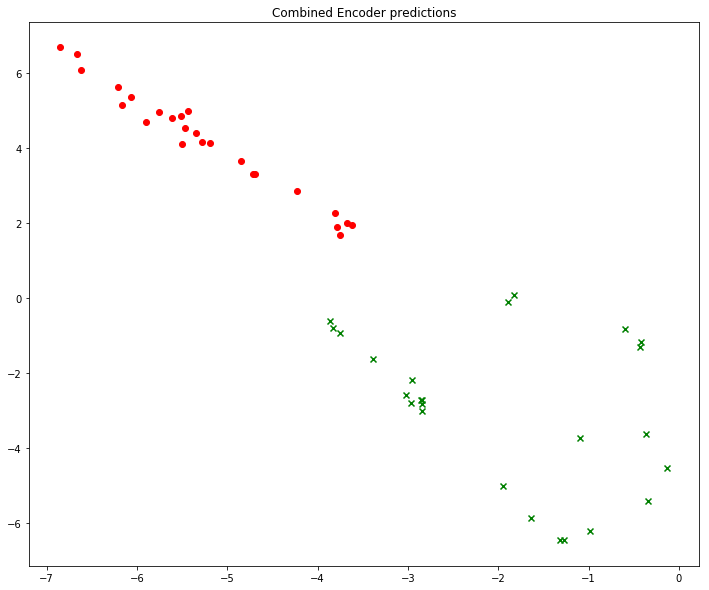

In [81]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:25,0], z_mean[:25,1], marker = 'o', c='r') #red- head
plt.scatter(z_mean[25:,0], z_mean[25:,1], marker = 'x', c='g') #green - heart
plt.title('Combined Encoder predictions')
plt.show()

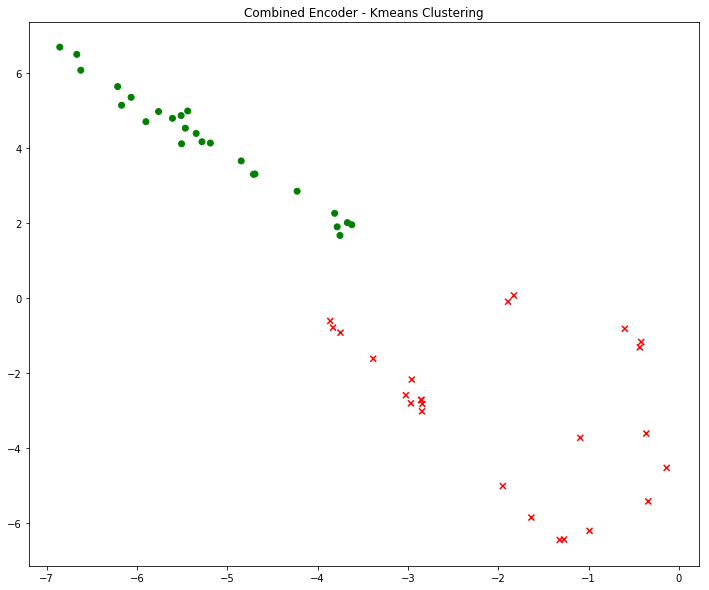

In [89]:
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(z_mean)

cluster_color = []
for i in y_pred:
    if i == 0:
        cluster_color.append('r')
    else:
        cluster_color.append('g')
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:25,0], z_mean[:25,1], marker = 'o', c=cluster_color[0:25])  #head
plt.scatter(z_mean[25:,0], z_mean[25:,1], marker = 'x', c=cluster_color[25:50])
plt.title("Combined Encoder - Kmeans Clustering")
plt.show()

In [90]:
head_mr_pd = pd.read_csv('head_mr_tags.csv')
heart_ct_pd = pd.read_csv('heart_ct_tags.csv')
head_mr_pd.shape, heart_ct_pd.shape

((50, 25), (190, 25))

In [91]:
img_pd = head_mr_pd.iloc[-25:]
img_pd2 = heart_ct_pd.iloc[-25:]
frames = [img_pd, img_pd2]
result = pd.concat(frames)
result.columns


Index(['manufacturer', 'mnf_model_name', 'magn_field_strength', 'sw_ver',
       'study_uid', 'series_uid', 'acqu_contrast', 'bolus_agent',
       'phase_contrast', 'study_desc', 'series_desc', 'code_meaning',
       'part_examined', 'img_type', 'pulse_seq_name', 'acq_dev_proc_desc',
       'scanning_seq', 'protocol_name', 'hidden_pulse_seq', 'slice_thickness',
       'img_patnt_orientation', 'laterality', 'image_laterality',
       'frame_laterality', 'bolus_agent_phase'],
      dtype='object')

In [92]:
thickness = np.array(result['slice_thickness'])

In [93]:
a = np.array(result['magn_field_strength'])
where_are_NaNs = np.isnan(a)
a[where_are_NaNs] = 0



In [94]:
LE = LabelEncoder()
result['part_examined'] = LE.fit_transform(result['part_examined'])
result['sw_ver'] = LE.fit_transform(result['sw_ver'])
result['manufacturer'] = LE.fit_transform(result['manufacturer'])
result['mnf_model_name'] = LE.fit_transform(result['mnf_model_name'])
result['study_desc'] = LE.fit_transform(result['study_desc'])
result['series_desc'] = LE.fit_transform(result['series_desc'])
result['protocol_name'] = LE.fit_transform(result['protocol_name'])

In [95]:
result.head(4)

,manufacturer,mnf_model_name,magn_field_strength,sw_ver,study_uid,series_uid,acqu_contrast,bolus_agent,phase_contrast,study_desc,...,acq_dev_proc_desc,scanning_seq,protocol_name,hidden_pulse_seq,slice_thickness,img_patnt_orientation,laterality,image_laterality,frame_laterality,bolus_agent_phase
25,0,0,1.5,1,1.3.6.1.4.1.14519.5.2.1.3320.3273.330990048303...,1.3.6.1.4.1.14519.5.2.1.3320.3273.278473693116...,NaN,NaN,NaN,0,...,NaN,EP,1,NaN,5.0,"['0.99939602557605', '-0.0146183905707', '0.03...",NaN,NaN,NaN,NaN
26,0,0,1.5,1,1.3.6.1.4.1.14519.5.2.1.3320.3273.330990048303...,1.3.6.1.4.1.14519.5.2.1.3320.3273.278473693116...,NaN,NaN,NaN,0,...,NaN,EP,1,NaN,5.0,"['0.99939602557605', '-0.0146183905707', '0.03...",NaN,NaN,NaN,NaN
27,0,0,1.5,1,1.3.6.1.4.1.14519.5.2.1.3320.3273.330990048303...,1.3.6.1.4.1.14519.5.2.1.3320.3273.278473693116...,NaN,NaN,NaN,0,...,NaN,EP,1,NaN,5.0,"['0.99939602557605', '-0.0146183905707', '0.03...",NaN,NaN,NaN,NaN
28,0,0,1.5,1,1.3.6.1.4.1.14519.5.2.1.3320.3273.330990048303...,1.3.6.1.4.1.14519.5.2.1.3320.3273.278473693116...,NaN,NaN,NaN,0,...,NaN,EP,1,NaN,5.0,"['0.99939602557605', '-0.0146183905707', '0.03...",NaN,NaN,NaN,NaN


In [96]:
part_examined = np.array(result['part_examined'])

In [97]:
## create a 2*TEST_SIZE x 9 tags + 2 z_mean
dicom_vector = np.zeros(shape=(TEST_SIZE*2 , (9+2)))
for i in range(TEST_SIZE*2):
    dicom_vector[i] = [
                       z_mean[i,0], 
                       z_mean[i,1], 
                       np.array(result['manufacturer'])[i],
                       np.array(result['mnf_model_name'])[i],
                       a[i],
                       np.array(result['sw_ver'])[i],
                       np.array(result['study_desc'])[i],
                       np.array(result['series_desc'])[i],        
                       np.array(result['part_examined'])[i],                       
                       np.array(result['protocol_name'])[i], 
                       thickness[i]
                       ]

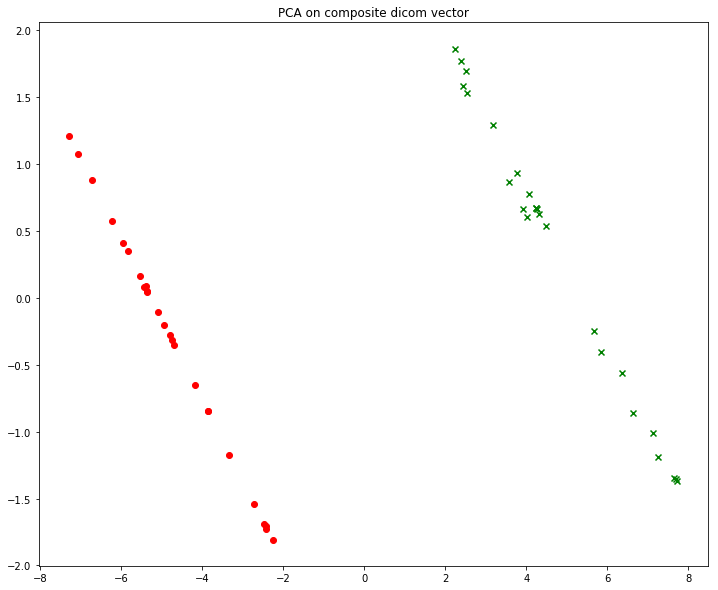

In [98]:
pca = PCA(n_components=2)
reduced_dicom_vector = pca.fit_transform(dicom_vector)
plt.figure(figsize=(12, 10))
plt.scatter(reduced_dicom_vector[:25,0], reduced_dicom_vector[:25,1], marker = 'o', c='r')
plt.scatter(reduced_dicom_vector[25:,0], reduced_dicom_vector[25:,1], marker = 'x', c='g')
plt.title("PCA on composite dicom vector")
plt.show()

In [99]:
## let's introduce errors in the dicom_vector to replicate erroroenous date
## let's add 3rd manufacturer and 3rd body part (even though we know the images belong to head or heart)


from random import randint
print(dicom_vector[:,2])
r = [randint(0, 49) for p in range(0, 20)] #40% 

for i in r:
    dicom_vector[i,2] = 1
    dicom_vector[i,5] = 1
print(dicom_vector[:,2])



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0.]


In [100]:
print(dicom_vector[:,8])
for i in r:
    dicom_vector[i,8] = 2
print(dicom_vector[:,8])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 2. 2. 0. 0. 2. 0. 0. 0. 2. 0. 2. 0. 2.
 2. 1. 1. 2. 2. 1. 1. 2. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 2. 2. 1. 1.
 1. 1.]


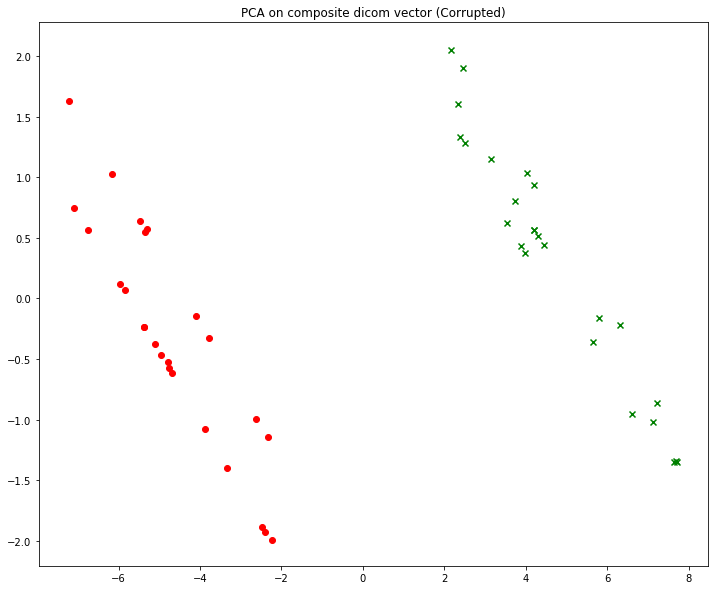

In [101]:
pca = PCA(n_components=2)
reduced_dicom_vector = pca.fit_transform(dicom_vector)
plt.figure(figsize=(12, 10))
plt.scatter(reduced_dicom_vector[:25,0], reduced_dicom_vector[:25,1], marker = 'o', c='r')
plt.scatter(reduced_dicom_vector[25:,0], reduced_dicom_vector[25:,1], marker = 'x', c='g')
plt.title("PCA on composite dicom vector (Corrupted)")
plt.show()